<a href="https://colab.research.google.com/github/jav0927/course-v3/blob/master/SSD_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SSD Single Shot  Multibox Object Detection
This model is a Fastai V1 iplementation of professor Jeremy Howard's work introduced in lesson 1 of 2018 Cutting  Edge Deep Learning for Coders, Part 2,  originally written in Fastai V0.7. This is the most challenging model in the course, but also a great instructional tool. In developing this model, i was inspired by previous work by Heye.

J. A. Villalobos @ 2019. wolves.lair@icloud.com

### Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore")

# import os
# NUM_PARALLEL_UNITS = 4
# os.environ["OMP_NUM_THREADS"] = "20"
# os.environ["KMP_BLOCKTIME"] = "0"
# os.environ["KMP_SETTINGS"] = "1"
# os.environ["KMP_AFFINITY"] = "granularity=fine, verbose, compact, 1, 0"


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# from google.colab import files

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
__version__

'1.0.61'

### Download Pascal 20007 database

In [4]:
# Download {Pascal 20007 database}
# path = untar_data(URLs.PASCAL_2007); path.ls()
path = Path('/home/helen/dataset/pascal_2007')
path.ls()

[PosixPath('/home/helen/dataset/pascal_2007/ssd_unfreeze_2_3.pth'),
 PosixPath('/home/helen/dataset/pascal_2007/segmentation'),
 PosixPath('/home/helen/dataset/pascal_2007/tps1_40step.npy'),
 PosixPath('/home/helen/dataset/pascal_2007/valid.json'),
 PosixPath('/home/helen/dataset/pascal_2007/ssd_basic.pth'),
 PosixPath('/home/helen/dataset/pascal_2007/test'),
 PosixPath('/home/helen/dataset/pascal_2007/ssd_unfreeze_2_2.pth'),
 PosixPath('/home/helen/dataset/pascal_2007/ssd_unfreeze_7.pth'),
 PosixPath('/home/helen/dataset/pascal_2007/PASCAL_VOC'),
 PosixPath('/home/helen/dataset/pascal_2007/fps1_40step.npy'),
 PosixPath('/home/helen/dataset/pascal_2007/train'),
 PosixPath('/home/helen/dataset/pascal_2007/PASCAL_VOC.zip'),
 PosixPath('/home/helen/dataset/pascal_2007/my_train'),
 PosixPath('/home/helen/dataset/pascal_2007/models'),
 PosixPath('/home/helen/dataset/pascal_2007/tmp'),
 PosixPath('/home/helen/dataset/pascal_2007/zhr_test'),
 PosixPath('/home/helen/dataset/pascal_2007/ssd_fre

### Data Preparation

In [5]:
# Deals with both GPU and CPU environments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
device

device(type='cuda')

In [6]:
# Collect image names, bound box coordinates, and categories into lists
# for train and test data sets
trn_im_names, trn_truths = get_annotations(path/'train.json')
val_im_names, val_truths = get_annotations(path/'valid.json')
tst_im_names, tst_truths = get_annotations(path/'test.json') 

# Combine Train and Validation set into a sigle dataset
# (which will be split later by the data block)
tot_im_names, tot_truths = [trn_im_names + val_im_names, trn_truths + val_truths]

# Create a dictionary containing the composite of the above
img_y_dict = dict(zip(tot_im_names, tot_truths))

# Define a function, based on the dictionary created above, to use in a Fastai Data Block to structure the input data
truth_data_func = lambda o: img_y_dict[o.name]

In [7]:
# len(tot_truths)
# 用来看bbox的area面积属性，来做统计直方图
annot = json.load(open(path/'train.json'))
id2images, id2bboxes, id2cats, id2area = {}, collections.defaultdict(list), collections.defaultdict(list), []
allHei, allWid,id2wid, id2hei = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
classes = {}
for o in annot['categories']:
    classes[o['id']] = o['name']        # 通过id对应name
for o in annot['annotations']:
    bb = o['bbox']
    area = o['area']
    id2bboxes[o['image_id']].append([bb[0], bb[1], bb[2], bb[3]])
    id2cats[o['image_id']].append(classes[o['category_id']])
    id2area.append(area)
    allHei[o['image_id']].append(bb[2])
    allWid[o['image_id']].append(bb[3])
for o in annot['images']:
    if o['id'] in id2bboxes:
        id2images[o['id']] = '' + o['file_name']
        id2wid[o['id']] = o['height']
        id2hei[o['id']] = o['width']
ids = list(id2images.keys())
# res = [id2images[k] for k in ids], 
res = [[id2bboxes[k], id2wid[k], id2hei[k],id2cats[k]] for k in ids]

In [8]:
res[0]

[[[155, 96, 196, 174]], 333, 500, ['car']]

In [9]:
# len(res[1][0])
res[1][2]
# res[1][0]
i = 0
j = 0
# min(res[i][j][2] / res[i][1], res[i][j][3] / res[i][2])
res[1][0][0]

[184, 61, 95, 138]

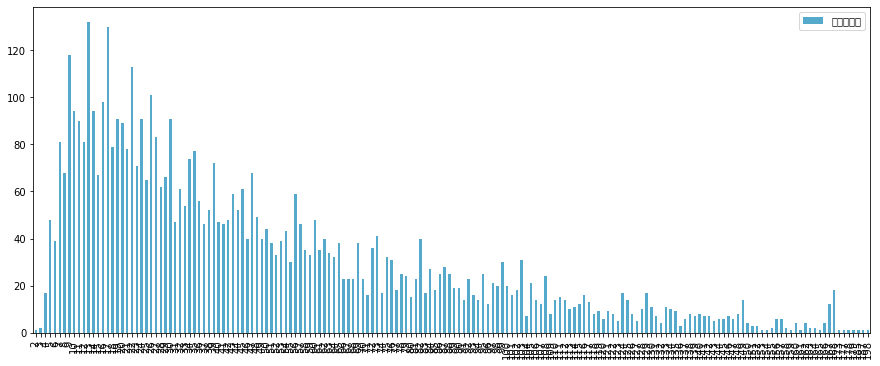

<Figure size 1080x432 with 0 Axes>

In [10]:
# len(res)
bbox_wh = []
for i in range(len(res)):
    for j in range(len(res[i][0]) - 1):
        wh = round(min(res[i][0][j][2] / res[i][1], res[i][0][j][3] / res[i][2]) * 224)
        bbox_wh.append(wh)

#统计所有的宽高比
bbox_wh_unique = set(bbox_wh)#set挑选出不重复的元素，即挑选出有多少种比例的anchors
#print(bbox_wh_unique)
bbox_count_unique = [bbox_wh.count(i) for i in bbox_wh_unique]#统计宽高比数量
#print(bbox_count_unique)

#画图
wh_dataframe = pd.DataFrame(bbox_count_unique, index=bbox_wh_unique, columns=['宽高比数量'])
wh_dataframe.plot(kind = 'bar', color="#55aacc", figsize=(15,6))
plt.figure(figsize=(15,6))
plt.show()
# ————————————————
# 版权声明：本文为CSDN博主「iddd」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
# 原文链接：https://blog.csdn.net/AWhiteDongDong/article/details/108269408

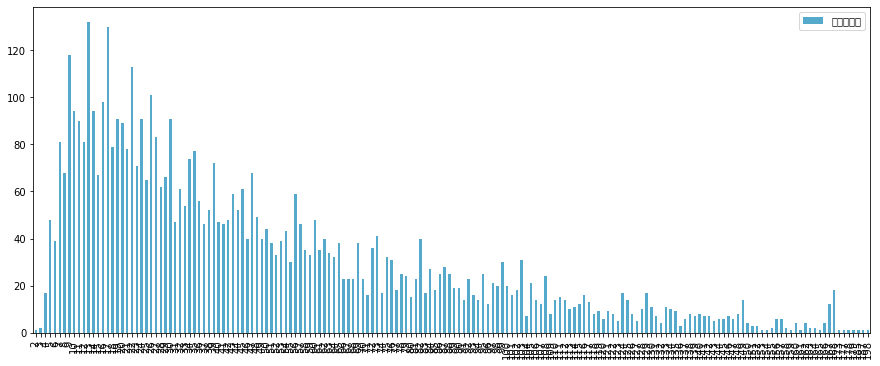

<Figure size 1080x432 with 0 Axes>

In [11]:
#画图
wh_dataframe = pd.DataFrame(bbox_count_unique, index=bbox_wh_unique, columns=['宽高比数量'])
wh_dataframe.plot(kind = 'bar', color="#55aacc", figsize=(15,6))
plt.figure(figsize=(15,6))
plt.show()

In [66]:
wh_dataframe[:15]

,宽高比数量
2,1
3,2
4,17
5,48
6,39
7,81
8,68
9,118
10,94
11,90


In [60]:
wh_dataframe[:15]
print(wh_dataframe[:15].cumsum())

    宽高比数量
2       1
3       3
4      20
5      68
6     107
7     188
8     256
9     374
10    468
11    558
12    639
13    771
14    865
15    932
16   1030


In [65]:
print(wh_dataframe.sum())
print(468/wh_dataframe.sum())

宽高比数量    5343
dtype: int64
宽高比数量    0.087591
dtype: float64


In [12]:
print(max(id2area), min(id2area))
print(min(allHei), min(allWid))
print(max(allHei), max(allWid))

227032 63
12 12
9961 9961


In [18]:
id2area
def plt_hist_pic(data_list, range_min, range_max, hist_size, xlabel_='x',ylabel_= 'y'):
    import matplotlib.pyplot as plt
    import numpy as np
    bins = np.arange(range_min, range_max, hist_size)
    plt.hist(data_list, bins, color='blue', alpha=0.5)
    plt.xlabel(xlabel_)
    plt.ylabel(ylabel_)
    plt.xlim(range_min, range_max)
    plt.show()

[34104,
 13110,
 81326,
 64227,
 29505,
 28747,
 42804,
 111101,
 53460,
 21824,
 28832,
 2340,
 950,
 950,
 77087,
 1674,
 3132,
 57330,
 14861,
 50806,
 54808,
 4059,
 35856,
 77938,
 62832,
 62040,
 122100,
 24182,
 138840,
 2989,
 84006,
 150500,
 44116,
 3822,
 215578,
 880,
 2574,
 1944,
 81090,
 19278,
 18762,
 44750,
 86913,
 101565,
 155818,
 68112,
 93903,
 7504,
 5712,
 13875,
 5995,
 5824,
 57236,
 53120,
 28148,
 71336,
 3124,
 525,
 900,
 15288,
 39368,
 92214,
 32240,
 1110,
 179725,
 55614,
 21756,
 19631,
 23958,
 91938,
 38927,
 161322,
 55896,
 5454,
 4512,
 105192,
 34270,
 27939,
 60543,
 32706,
 43400,
 144211,
 136718,
 1386,
 1368,
 780,
 483,
 702,
 990,
 1178,
 5490,
 435,
 864,
 868,
 59019,
 378,
 4081,
 158364,
 122451,
 5076,
 5475,
 25878,
 78899,
 124559,
 49920,
 49910,
 15104,
 132822,
 38610,
 72180,
 93436,
 58080,
 121660,
 75192,
 7872,
 156612,
 78769,
 125249,
 29106,
 10502,
 1120,
 13462,
 11324,
 31948,
 22473,
 40194,
 26070,
 988,
 1980,
 13

In [7]:
len(trn_im_names),len(trn_truths),len(val_im_names),len(tst_im_names),len(tot_im_names)

(2501, 2501, 2510, 4952, 5011)

In [8]:
img_y_dict

{'000012.jpg': [[[96, 155, 270, 351]], ['car']],
 '000017.jpg': [[[61, 184, 199, 279], [77, 89, 336, 403]],
  ['person', 'horse']],
 '000023.jpg': [[[229, 8, 500, 245],
   [219, 229, 500, 334],
   [177, 1, 500, 90],
   [0, 1, 369, 117],
   [1, 2, 462, 243],
   [0, 224, 486, 334]],
  ['bicycle', 'bicycle', 'bicycle', 'person', 'person', 'person']],
 '000026.jpg': [[[124, 89, 212, 337]], ['car']],
 '000032.jpg': [[[77, 103, 183, 375],
   [87, 132, 123, 197],
   [179, 194, 229, 213],
   [188, 25, 238, 44]],
  ['aeroplane', 'aeroplane', 'person', 'person']],
 '000033.jpg': [[[106, 8, 263, 499],
   [199, 420, 226, 482],
   [187, 324, 223, 411]],
  ['aeroplane', 'aeroplane', 'aeroplane']],
 '000034.jpg': [[[166, 115, 400, 360], [152, 140, 229, 333]],
  ['train', 'train']],
 '000035.jpg': [[[95, 0, 361, 191],
   [97, 217, 318, 465],
   [194, 467, 317, 500],
   [303, 2, 375, 500]],
  ['person', 'person', 'person', 'diningtable']],
 '000036.jpg': [[[78, 26, 344, 319]], ['dog']],
 '000042.jpg': 

In [65]:
img_idx
# bbox

[[[171, 68, 330, 270],
  [140, 149, 284, 229],
  [200, 284, 331, 327],
  [197, 257, 329, 297]],
 ['horse', 'person', 'person', 'person']]

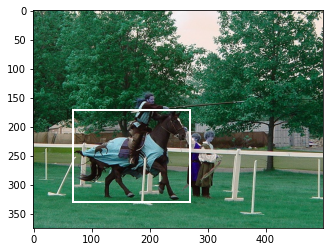

In [66]:
img_idx = img_y_dict['000009.jpg']
# img_idx
import cv2
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH + cv2.IMREAD_ANYCOLOR
im = cv2.imread(str(path/'train'/'000009.jpg'), flags).astype(np.float32) / 255
bbox = img_idx[0][0] # y1, x1, y2, x2

def bb_to_hw(bb): return [bbox[1], bbox[0], bbox[3]-bbox[1], bbox[2]-bbox[0]]
hw = bb_to_hw(bbox)

fig, ax = plt.subplots(1,1)
ax.imshow(im)                           # (col, row, width, height)
# patch = ax.add_patch(patches.Rectangle([bbox[1], bbox[0]],bbox[3]-bbox[1], bbox[2]-bbox[0], fill=False, edgecolor='white', lw=2))
patch = ax.add_patch(patches.Rectangle(hw[:2], hw[2], hw[3], fill=False, edgecolor='white', lw=2))

### Create Fastai DataBunch

In [12]:
sz=224       # Image size
bs=64        # Batch size

In [19]:
np.random.seed(35)
tfms = get_transforms(cutout(n_holes=(1,4), length=(10, 160), p=.5), max_rotate=4., max_zoom=1.1, p_affine=0.5, p_lighting=0.5 )
data = (ObjectItemList
        .from_folder(path/'train') # 文件夹中有9961个img
        .split_by_rand_pct(0.5)
        .label_from_func(truth_data_func) 
        .transform(tfms=tfms,size=sz,tfm_y=True,resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs,collate_fn=bb_pad_collate,num_workers=8)
        .normalize(imagenet_stats)
       )

In [20]:
data

ImageDataBunch;

Train: LabelList (2506 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Valid: LabelList (2505 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Test: None

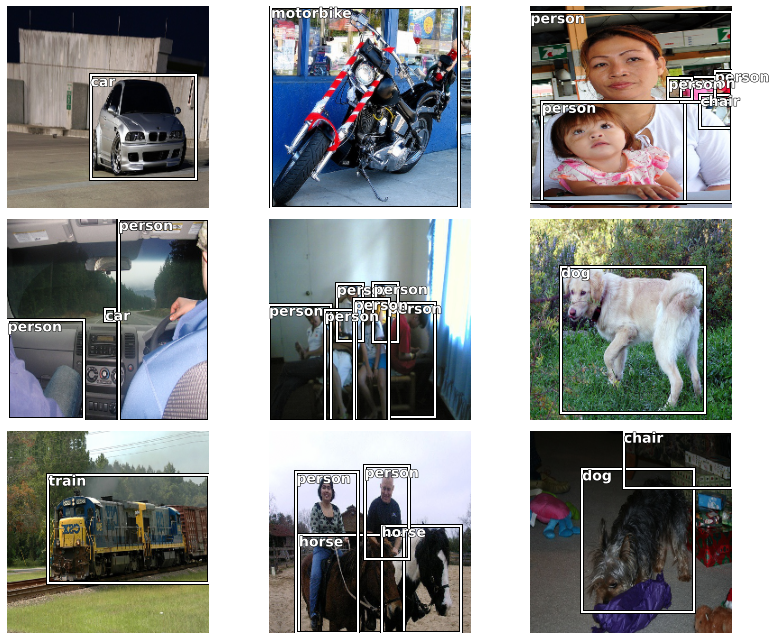

In [21]:
data.show_batch(rows=3, figsize=(12,9))

### Show single image

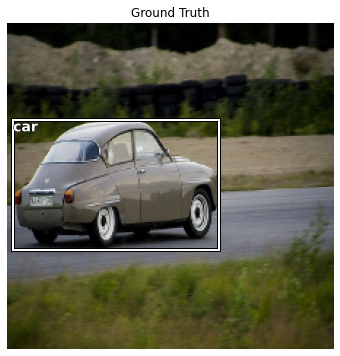

In [22]:
idx = 48

xb, yb= next(iter(data.valid_dl)) # valid_dl就100张图片

img = vision.Image(denormalize(xb[idx], *tensor(imagenet_stats)))
img_box = ImageBBox.create(sz, sz, yb[0][idx].cpu(), labels=yb[1][idx], classes=data.classes, scale=False)

fig, axes = plt.subplots(1, 1, figsize=(10,6))
img.show(ax=axes, y=img_box, title="Ground Truth")

### Helper Functions 

In [23]:
# Filter out all zero-valued bounding boxes
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]

# Calculate the area of a bounding box
def box_area(boxes):
    return (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

# Calculate the intersection of two given bounding boxes
def intersect(box_a,box_b):
    #make sure box_a and box_b exists, otherwise undefine behavior if you call the func
    top_left = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    bot_right = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp((bot_right - top_left),min=0)
    return inter[:,:,0] * inter[:,:,1]

# Calculate Jaccard (IOU)
def iou(bbox,anchor):
    #bbox is gt_bb, anchor is anchor box, all in fastai style
    if len(bbox.shape) == 1: bbox = bbox[None,...]
    inter = intersect(bbox,anchor)
    union = box_area(bbox).unsqueeze(dim=1) + box_area(anchor).unsqueeze(dim=0) - inter #to broadcast shape to (N,16),where N is number of gt_bb for single image
    return inter / union

# Display generated anchor grid
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

#convert center/height/width to fastai top left and bottom right coordinates
def cthw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bot = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bot,right],dim=1)

# Transform activations to bounding box format
def act_to_bbox(activation,anchor):
    activation = torch.tanh(activation) #force scale to be -1,1
    act_center = anchor[:,:2] + (activation[:,:2]/2 * grid_sizes.float().to(activation.device))
    act_hw = anchor[:,2:] * (activation[:,2:]/2 + 1)
    return cthw2corners(torch.cat([act_center,act_hw],dim=1))

  # Map to Ground Truth
def map_to_gt(overlaps):
    prior_overlap,prior_idx = overlaps.max(dim=1)
    sec_overlap,sec_idx = overlaps.max(dim=0)
    sec_overlap[prior_idx] = 4.99
    for i,o in enumerate(prior_idx): 
        sec_idx[o] = i
    return sec_overlap,sec_idx

### Helper Functions - Anchor Boxes

In [24]:

anc_grids = [4, 2, 1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
# *** Number of Anchor Scales
k = len(anchor_scales)
# ***************************

anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
anchor_cnr = cthw2corners(anchors)


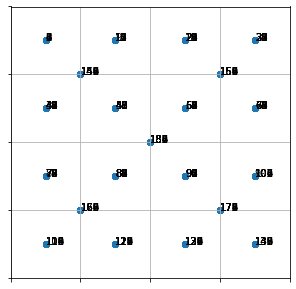

In [25]:
show_anchors(anchors,(4,4))

### Optimal Learning Rate Search

In [46]:
def is_unfreeze(learner):
    '''
    Determines whether the next-to-last layer in the model is set to unfreeze or freeze
    '''
    c = 0
    for each in list(learner.model.body[-1][0].parameters()):
          if each.requires_grad: c += 1   
    if c == len(list(learner.model.body[-1][0].parameters())):
          return True 
    else:
          return False

import pdb
  
def find_optimal_lr(learner, noise=5, show_df=None, show_min_values=False):
    '''
    Parameters 先执行lr_find，再从中自动找到最优的学习率
    
      learner:  The learner (mandatory)
      
      (Optional) 滤波参数
      noise:   Filtering parameter, set to 5. Suggest no to modify this value
      
      show_df: 'head' - Show the top 50 rows, 
               'tail' - Show the tail 50 rows
    
      show_min_values: True  - Display all values, min, and max 
                       False - Display min_loss and max_grad values
    
    Returns:
      optimun_lr - if freeze = True
      Suggested Best Slice - if freeze = False
      
    Author:  J. Adolfo Villalobos @ 2019  
    '''
    
    # Get loss values, corresponding gradients, and lr values from model.recorder 获取loss的最小，grad的最小值
    loss = np.array(learner.recorder.losses)
    loss_grad = np.gradient(loss)   
    # Transform lrs list to np array 将学习率转为numpy格式
    lrs = np.array(learner.recorder.lrs, dtype='float32')
    
    # Create a DataFrame with the data
    data = {'loss': loss.T, 'loss_grad': loss_grad.T, 'lrs': lrs.T}
    # 使用panda来计算足校和最大值
    df = pd.DataFrame(data, columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])
      
    # Populate "min" and "max" columns for loss and gradient values filtering the noise with argrelextrema.     
    from scipy.signal import argrelextrema
    
    #********
    # IMPORTANT: n filters noise (sharp spikes in the data). Higher n value filters noise more aggressively. 
    # n = 5 seems to work best
    n=noise    
    #********
    
    df.min_loss = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df.max_loss = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df.min_grad = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df.max_grad = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Optional: Display dataframe if show_df=True
    if show_df == 'head': print(df.head(50)) 
    elif show_df == 'tail': print(df.tail(50))     
        
    # Plot losses and loss gradients against lr values
    plt.figure(figsize=[8, 5])
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()
    color_loss = 'blue'
    color_grad = 'orange'
    color_green = 'green'
    color_red = 'red'

    ax.xaxis.grid(True) # x轴画上分割线
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color_loss)
    ax.semilogx(df.lrs, df.loss, c=color_loss )# loss随着lr变化的曲线
    
    # Define variable vertical size of the plot window, depending on the graph shape
    u_limit = max(df.loss.loc[(df.lrs < 0.1)].max(), 250)*2    
    ax.set_ylim([-200, u_limit])#y轴的数据有大小限制
   
    # Plot resulting line graphs
    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color= color_grad)
    ax2.semilogx(df.lrs, df.loss_grad, c = color_grad)
    ax2.tick_params(axis='y', labelcolor = color_grad)
    
    # plot inflection points，红色是最小值
    ax.scatter(df.lrs, df.min_loss, c = color_red)    
    ax2.scatter(df.lrs, df.min_grad, c = color_red)    
    if show_min_values:# 绿色为最大值
        ax.scatter(df.lrs, df.max_loss, c = color_green)
        ax2.scatter(df.lrs, df.max_grad, c = color_green) 
    
    # Legends
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(labels=['loss','min_loss'], loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(labels=['loss_grad','min_grad'], loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()
    
    # Display resulting lr values, format varies depending of the state of the model's 
    # next-to-last layer ggroup: set to freeze or unfreeze    看模型的最后层是否是冻结状态
    if is_unfreeze(learn):
        # Yellow min_grad graph
        rev_tru_idx = df.min_grad.notna()[::-1]   
        optimun_lr_upper_bound_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
        rev_tru_idx[rev_tru_idx.idxmax()] = False
        
#         pdb.set_trace()
        
        optimun_lr_lower_bound_1_g = df.lrs.iloc[rev_tru_idx.idxmax()]
        rev_tru_idx[rev_tru_idx.idxmax()] = False     
        optimun_lr_lower_bound_2_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      
        # Blue loss graph
        rev_tru_idx_loss = df.min_loss.notna()[::-1]   
        optimun_lr_upper_bound_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
        rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = False    
        optimun_lr_lower_bound_1_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()]
        rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = False   
        optimun_lr_lower_bound_2_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 

        # Print results and return choices of lr slice
        print('Model set to: "unfreeze" or "freeze_to:"')      
        data = {'*Gradient - Orange Graph*' : [optimun_lr_upper_bound_g, optimun_lr_lower_bound_1_g, optimun_lr_lower_bound_2_g], 
              '*Loss - Blue Graph*' : [optimun_lr_upper_bound_l, optimun_lr_lower_bound_1_l, optimun_lr_lower_bound_2_l]}
        prdf = pd.DataFrame(data, index = ['First choice lr:', 'Second choice lr:', 'Third choice lr:' ])
        pd.options.display.float_format = '{:.10E}'.format
        #prdf.style.applymap('color: %s' % color_grad, subset=['*Gradient - Orange Graph*'])
        print(prdf)

        return optimun_lr_lower_bound_1_g, optimun_lr_upper_bound_g
      
    else:
        optimun_lr_upper_bound = df.lrs.iloc[df.min_grad.notna()[::-1].idxmax()]
        optimun_lr_lower_bound = df.lrs.iloc[df.min_loss.notna()[::-1].idxmax()]/10
        # Print results and return optimal lr
        print('Model set to "freeze":')
        print('  Optimun lr: {:.10E} '.format(optimun_lr_upper_bound))
        print('  Min loss divided by 10: {:.10E}'.format(optimun_lr_lower_bound))
        return optimun_lr_upper_bound 
     

### Model
为了解决目标检测的问题，Torch建立一个custom model。网络架构为SSD

这个模型使用一个预训练的ResNet网络，同时在骨干网络之后加上目标检测的检测头head。最初的设计和测试，我们使用resnet34

To solve this object detection problem, we are going to create a custom model using Torch.
The architecture chosen is Single Shot Detection, described in the paper SSD: Single Shot Multibox Detector by Wei Liu, et. al.
The model uses a pretrained ResNet, to which we add the components required for object detection. For initial design and testing, we use ResNet34.

In [27]:
# Number of classes in the data set
no_cls = len(data.classes); no_cls

21

In [28]:
# model 
f_model = models.resnet34

In [29]:
# Method used to match the shape of the conv_ssd_layer to the ground truth's shape
def y_handoff (x,k):
    # Reshape ssd output to match truth's shape 
    # Must return size of bs,r*c,nf
    # y structure is (16,4),(16,21) single item style
    bs,nf,row,col = x.shape
    x = x.view(bs,nf//k,-1)
    return x.permute(0,2,1)
    

# Standard convolution with stride=2 to halve the size of the image
class conv2_std_layer(nn.Module):
    def __init__(self, ni, nf, stride=2, drop=0.1):
        super().__init__()
        self.cnv = conv_layer(ni, nf, stride=stride)
        self.drp = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drp(self.cnv(x))

# SSD convolution that camptures bounding box and class
class conv2_ssd_layer(nn.Module):
    def __init__(self, ni, k, no_cls):
        super().__init__()
        self.k = k 
        self.conv_class = conv2d(ni, no_cls*self.k, bias=True)
        self.conv_bbox = conv2d(ni, 4*self.k, bias=True)
        #self.conv_class.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        label = self.conv_class(x)
        box = self.conv_bbox(x)
        return [y_handoff(box, self.k), y_handoff(label, self.k)]

In [30]:
class ssd_model(nn.Module):
    def __init__(self, arch=models.resnet34, k=9 , drop=0.4, no_cls=21):
        super().__init__()
        self.k = k
        self.body = create_body(arch)
        self.drop = nn.Dropout(0.2)   # it was 0.25

        self.std_conv_0 = conv2_std_layer(num_features_model(self.body), 256, drop=drop,stride=1)
        # Dimension-reducing  layers
        self.std_conv_1 = conv2_std_layer(256, 256, drop=drop, stride=2) # 4 by 4 layer
        self.std_conv_2 = conv2_std_layer(256, 256, drop=drop, stride=2) # 2 by 2 layer
        self.std_conv_3 = conv2_std_layer(256, 256, drop=drop, stride=2) # 1 by 1 layer
        # Standard layers
        self.ssd_conv_1 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_2 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_3 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        
    def forward(self, xb):
        xb = self.drop(F.relu(self.body(xb)))
        xb = self.std_conv_0(xb)
        xb = self.std_conv_1(xb)
        bb1, cls1 = self.ssd_conv_1(xb) # 4 x 4
        xb = self.std_conv_2(xb)
        bb2, cls2 = self.ssd_conv_2(xb) # 2 x 2
        xb = self.std_conv_3(xb)     
        bb3, cls3  = self.ssd_conv_3(xb) # 1 x 1
        
        return [torch.cat([bb1, bb2, bb3], dim=1), 
                torch.cat([cls1, cls2, cls3], dim=1)]

### SSD Loss

---


In [31]:
# Focal loss implementation
def get_weight(x,t):
    x,t = x.cpu(),t.cpu()
    alpha,gamma = 0.25,1
    p = x.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
    
# Class loss computation, based on Binary Cross Entrophy with Logits
def bceloss(pred,target,num_classes,focal_loss=False):
    
    t = torch.eye(num_classes)[target.detach().cpu()][:,1:]
    p = pred[:,1:]
    
    w = get_weight(p,t) if focal_loss else None
    return F.binary_cross_entropy_with_logits(p.cpu(),t,weight=w.detach(),reduction='sum') / (num_classes-1)

# Bounding-box loss computation, based on fixed Anchor Boxes and L! Loss
def single_ssd_loss(pbox,plabel,box,label):
  
    # Compute the jaccard (overlap) between ground truth and anchor boxes
    anchor_box = anchors
    base_box = cthw2corners(anchor_box) # Map anchors into Fastai format: top-left and bottom-right coordinates
    bbox,clas = un_pad(box,label) # Filter all non-zero boxes
    overlaps = iou(bbox,base_box.to(device))  # Calculate iou for anchor and target box
    try:
        gt_overlaps,gt_idx = map_to_gt(overlaps)
    except:
        return 0,0
    # Map gt_idx back to classes for multi label classfication
    gt_clas = clas[gt_idx]
    
    # Positive predictions have overlaps greater than 0.4
    pos = gt_overlaps > 0.4
    gt_clas[~pos] = len(data.classes)
    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_clas.detach()] #Ground truth labels
    pos_idx = torch.nonzero(pos)[:,0] 
    gt_bbox = bbox[gt_idx]  # Selected ground truth box
    
    # Map predicted bounding box to anchor and convert it to Fastai format: top-left and bottom-right coordinates
    p_final_box = act_to_bbox(pbox,anchor_box.to(device)) 
    
    #L1 loss calculation
    loc_loss = ((p_final_box[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    
    #Multi classification
    label_loss = bceloss(plabel,tensor(gt_label),data.c,focal_loss=True)
    return loc_loss,label_loss

# Loop through each of the y_hat and y pairs 
def ssd_loss(preds,*targets,print_it=False):
    batch_loc_loss,batch_label_loss = 0., 0.
    for p_box,p_label,box,label in zip(*preds,*targets):
        loc_loss,label_loss = single_ssd_loss(p_box,p_label,box,label)
        batch_loc_loss = batch_loc_loss + loc_loss
        batch_label_loss = batch_label_loss + label_loss
    total_loss = batch_loc_loss + batch_label_loss.to(device)
    if print_it: print(batch_loc_loss,batch_label_loss)
    return total_loss
  
# loss function
loss_f = ssd_loss

### Learner

In [32]:
md = ssd_model(f_model, k=k, no_cls=no_cls, drop=0.3)

In [80]:
# from nb_06 import *
# ??VOCmAP_at_IoU50
# ??mAP_at_IoU40

In [81]:
from external.mean_average_precision_source import MetricBuilder
from fastai.callback import *
from fastai.torch_core import *
from functools import partial

class mAP_Metric():
    "Metric to calculate mAP for different IoU thresholds"
    def __init__(self, iou_thresholds, recall_thresholds=None, mpolicy="greedy", name="mAP", remove_background_class=True):
        self.__name__ = name
        self.iou_thresholds = iou_thresholds
        self.recall_thresholds = recall_thresholds
        self.mpolicy = mpolicy
        self.remove_background_class = remove_background_class

    def __call__(self, preds, targs, num_classes):
        if self.remove_background_class:
            num_classes=num_classes-1
        #metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=num_classes)
        metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=num_classes)
        for sample_preds, sample_targs in self.create_metric_samples(preds, targs):
            metric_fn.add(sample_preds, sample_targs)
        metric_batch = metric_fn.value(iou_thresholds=self.iou_thresholds,
                                       recall_thresholds=self.recall_thresholds,
                                       mpolicy=self.mpolicy)['mAP']
        return metric_batch

    def create_metric_samples(self, preds, targs):
        pred_samples = []
        for pred in preds:
            res = torch.cat([pred["boxes"], pred["labels"].unsqueeze(-1), pred["scores"].unsqueeze(-1)], dim=1)
            pred_np = res.detach().cpu()#.numpy()
            if self.remove_background_class:
                # first idx is background
                try:
                    pred_np= pred_np-np.array([0,0,0,0,1,0])
                except: pass
            pred_samples.append(pred_np)

        targ_samples = []
        for targ in targs: # targs : yb[0]
            targ = torch.cat([targ["boxes"],targ["labels"].unsqueeze(-1)], dim=1)
            targ = torch.cat([targ, torch.zeros([targ.shape[0], 2], device=targ.device)], dim=1)
            targ_np = targ.detach().cpu()
            #targ_np = np.array(targ.detach().cpu())
            if self.remove_background_class:
                # first idx is background
                try:
                    targ_np= targ_np-np.array([0,0,0,0,1,0,0])
                except: pass
            targ_samples.append(targ_np)

        return [s for s in zip(pred_samples, targ_samples)]


class _AvgMetric_ObjectDetection(Callback):
    def __init__(self, func):
        name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        self.val, self.count = 0., 0

    def on_batch_end(self, last_output, last_target, **kwargs):
        if not is_listy(last_target): last_target = [last_target]
        import pdb
        pdb.set_trace()
        bs = last_target[0].size[0] # batch大小，size的第一个。
        val = self.func(last_output, *last_target, num_classes=21)
        self.val += val.detach().cpu() * bs
        self.count += bs
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.val/self.count if self.count != 0 else None)


def create_mAP_metric(iou_tresh, recall_thresholds, mpolicy, metric_name, remove_background_class=True):
    """ Creates a function to pass into learner for measuring mAP.
    iou_tresh: float or np.arange, f.e.: np.arange(0.5, 1.0, 0.05)
    recall_thresholds: None or np.arange, f.e.: np.arange(0., 1.01, 0.01)
    mpolicy: str, 'soft' or 'greedy'
    metric_name: str, name to display in fastai´s recorder
    remove_background_class: True or False, remove first index before evaluation, as it represents background class in our dataloader
    Metric Examples:
    COCO mAP: set recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy="soft"
    VOC PASCAL mAP: set recall_thresholds=np.arange(0., 1.1, 0.1), mpolicy="greedy"
    VOC PASCAL mAP in all points: set recall_thresholds=None, mpolicy="greedy"
    """
    return _AvgMetric_ObjectDetection(mAP_Metric(iou_tresh, recall_thresholds=recall_thresholds, mpolicy=mpolicy,
                                                    name=metric_name, remove_background_class=True))

# coco mAP
VOCmAP_at_IoU50 = _AvgMetric_ObjectDetection(mAP_Metric(0.5, recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy="greedy",
                                                    name="VOCmAP@IoU>0.5", remove_background_class=True))
mAP_at_IoU40 = _AvgMetric_ObjectDetection(mAP_Metric(0.4, recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy="soft",
                                                    name="mAP@IoU>0.4", remove_background_class=True))
mAP_at_IoU50 = _AvgMetric_ObjectDetection(mAP_Metric(0.5, recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy="soft",
                                                    name="mAP@IoU>0.5", remove_background_class=True))
mAP_at_IoU60 = _AvgMetric_ObjectDetection(mAP_Metric(0.6, recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy="soft",
                                                    name="mAP@IoU>0.6", remove_background_class=True))
mAP_at_IoU70 = _AvgMetric_ObjectDetection(mAP_Metric(0.7, recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy="soft",
                                                    name="mAP@IoU>0.7", remove_background_class=True))
mAP_at_IoU80 = _AvgMetric_ObjectDetection(mAP_Metric(0.8, recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy="soft",
                                                    name="mAP@IoU>0.8", remove_background_class=True))
mAP_at_IoU90 = _AvgMetric_ObjectDetection(mAP_Metric(0.9, recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy="soft",
                                                    name="mAP@IoU>0.9", remove_background_class=True))
mAP_at_IoU50_95 = _AvgMetric_ObjectDetection(mAP_Metric(np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy="soft",
                                                    name="mAP@IoU 0.5:0.95", remove_background_class=True))

In [39]:
learn = Learner(data, md, loss_func=loss_f)

### Split Model

In [40]:
learn.model.drop

Dropout(p=0.2, inplace=False)

In [41]:
learn.split(lambda m: (m.body[6], m.drop))
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace=True)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace=True)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, mom

In [36]:
learn.model

ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Fit

In [43]:
learn.freeze()

In [47]:
# Find Finder
learn.lr_find()

epoch,train_loss,valid_loss,time
0,5575.332031,#na#,00:47
1,2567.757324,#na#,00:45


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


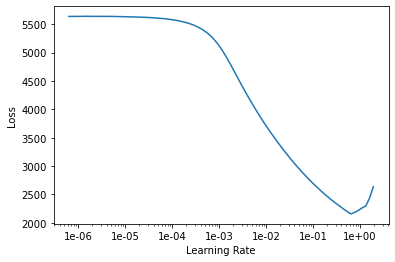

In [48]:
learn.recorder.plot()

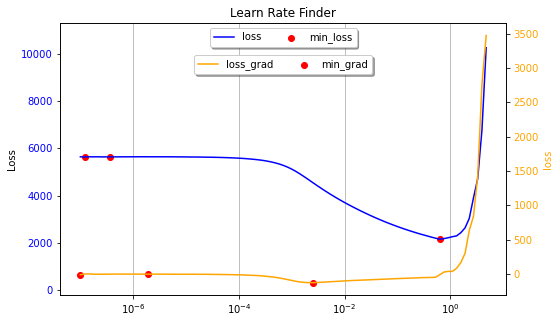

Model set to "freeze":
  Optimun lr: 2.5118864141E-03 
  Min loss divided by 10: 6.3095736504E-02


In [49]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn)

In [50]:
learn.fit_one_cycle(1, 2.5118864141E-03) # BCE loss

epoch,train_loss,valid_loss,time
0,976.658875,180.509705,01:22


In [51]:
learn.save(path/'ssd_basic')

In [52]:
learn.load(path/'ssd_basic', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (2506 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Valid: LabelList (2505 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mo

In [53]:
mAP()

NameError: name 'mAP' is not defined

#### Train Last Two Layers

In [54]:
learn.split(lambda m: (m.body[6],m.drop))
learn.freeze_to(-2)

In [55]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,173.312836,#na#,00:51
1,216.296570,#na#,00:52


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


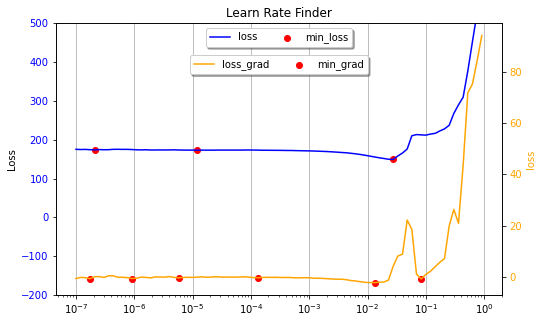

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            8.3176374435E-02     2.7542287484E-02
Second choice lr:           1.3182567433E-02     1.2022644114E-05
Third choice lr:            1.3182566909E-04     2.0892960606E-07


In [56]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn)

In [57]:
learn.fit_one_cycle(10, slice(1e-5, 3.9810716407E-04))

epoch,train_loss,valid_loss,time
0,171.699722,156.101883,01:27


KeyboardInterrupt: 

: 

In [ ]:
learn.save(path/'ssd_freeze_2_1')

In [ ]:
learn.load(path/'ssd_freeze_2_1', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mod

In [45]:
learn.split(lambda m: (m.body[6],m.drop))
learn.freeze_to(-2)

In [46]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,71.484215,#na#,01:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


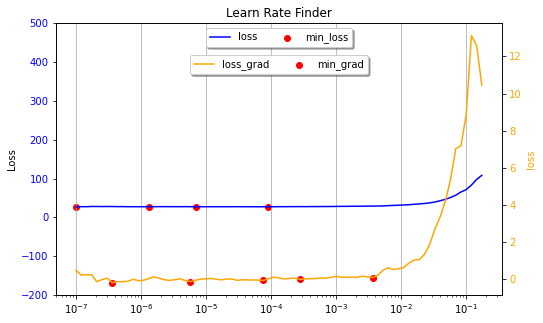

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            3.6307806149E-03     9.1201087344E-05
Second choice lr:           2.7542287717E-04     6.9183097366E-06
Third choice lr:            7.5857758929E-05     1.3182567500E-06


In [47]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn)

In [48]:
learn.fit_one_cycle(10, slice(9.1201087344E-05))

epoch,train_loss,valid_loss,time
0,27.844709,21.145702,01:04
1,27.937737,21.458168,01:07
2,27.853863,21.471844,01:05
3,27.081474,20.733833,01:07
4,25.904884,19.802378,01:06
5,24.968847,19.347889,01:06
6,24.166254,18.792204,01:06
7,23.493130,18.193174,01:06
8,22.921225,18.115459,01:06
9,22.578480,18.041357,01:07


In [49]:
learn.save(path/'ssd_unfreeze_2_2')

In [50]:
learn.load(path/'ssd_unfreeze_2_2', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mod

In [51]:
learn.split(lambda m: (m.body[6], m.drop))
learn.freeze_to(-2)

In [52]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,57.938343,#na#,01:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


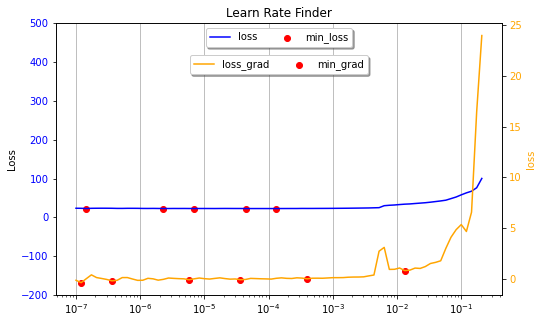

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            1.3182567433E-02     1.3182566909E-04
Second choice lr:           3.9810716407E-04     4.3651583837E-05
Third choice lr:            3.6307807022E-05     6.9183097366E-06


In [53]:
lr = find_optimal_lr(learn)

In [54]:
learn.fit_one_cycle(13, slice(2.7542287717E-05, 1.3182566909E-04 ))

epoch,train_loss,valid_loss,time
0,22.627010,18.082561,01:03
1,22.468229,18.041332,01:08
2,22.647675,18.052166,01:08
3,22.477438,18.132187,01:07
4,22.214458,18.131149,01:06
5,22.067528,18.094511,01:05
6,21.913210,18.032511,01:05
7,21.658066,17.840263,01:06
8,21.247416,17.659565,01:05
9,20.963133,17.673212,01:06


In [55]:
learn.save(path/'ssd_unfreeze_2_3')

In [56]:
learn.load(path/'ssd_unfreeze_2_3', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mod

#### Unfreeze and Train

In [57]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [58]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,69.244606,#na#,01:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


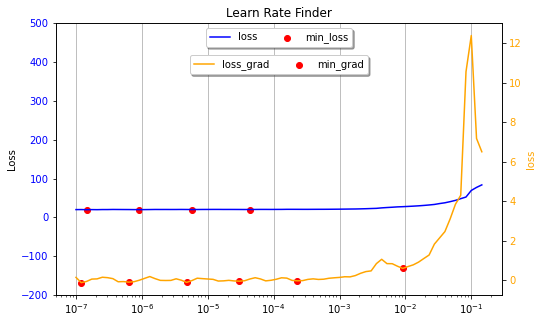

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            9.1201085597E-03     4.3651583837E-05
Second choice lr:           2.2908677056E-04     5.7543993535E-06
Third choice lr:            3.0199516914E-05     9.1201081887E-07


In [59]:
lr = find_optimal_lr(learn)

In [60]:
learn.fit_one_cycle(13, slice(4.3651583837E-05 ))

epoch,train_loss,valid_loss,time
0,20.646648,17.566109,01:07
1,20.656839,17.603964,01:09
2,20.438576,17.551390,01:09
3,20.532774,17.505749,01:09
4,20.517473,17.510130,01:09
5,20.356970,17.534798,01:08
6,20.374069,17.473598,01:08
7,20.442078,17.458994,01:09
8,20.336382,17.443041,01:09
9,20.183193,17.409866,01:09


In [61]:
learn.save(path/'ssd_unfreeze_4')

In [62]:
learn.load(path/'ssd_unfreeze_4', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mod

In [63]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [64]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,58.831314,#na#,01:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


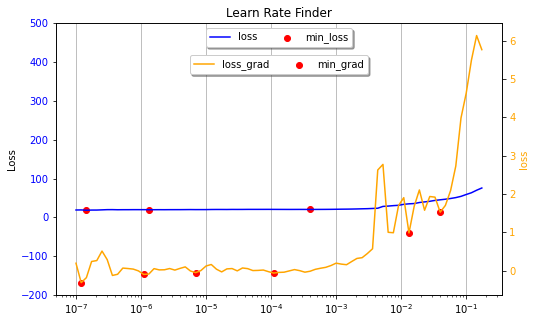

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            3.9810717106E-02     3.9810716407E-04
Second choice lr:           1.3182567433E-02     1.3182567500E-06
Third choice lr:            1.0964782268E-04     1.4454397501E-07


In [65]:
lr = find_optimal_lr(learn)

In [66]:
learn.fit_one_cycle(13, slice(3.9810716407E-04))

epoch,train_loss,valid_loss,time
0,20.096460,17.338017,01:06
1,20.350376,17.654055,01:09
2,20.547482,17.706615,01:09
3,20.773323,18.007645,01:09
4,20.705378,17.811815,01:10
5,20.563438,17.610228,01:09
6,20.117081,17.365906,01:10
7,19.750051,17.363098,01:08
8,19.352936,16.926096,01:09
9,19.053604,16.881197,01:10


In [74]:
learn.save(path/'ssd_unfreeze_5')

In [76]:
learn.load(path/'ssd_unfreeze_5', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mod

In [77]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [78]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,56.460918,#na#,01:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


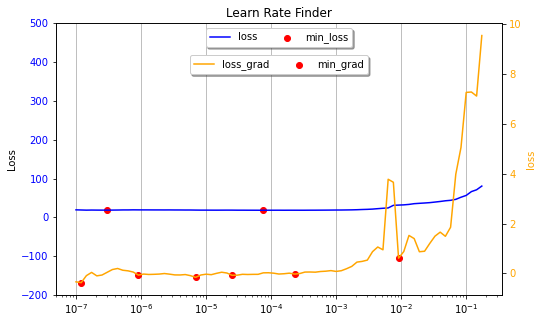

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            9.1201085597E-03     7.5857758929E-05
Second choice lr:           2.2908677056E-04     3.0199518619E-07
Third choice lr:            2.5118864869E-05     1.7378008366E-01


In [79]:
lr = find_optimal_lr(learn)

In [80]:
learn.fit_one_cycle(13, slice(7.5857758929E-05))

epoch,train_loss,valid_loss,time
0,18.510809,16.813427,01:06
1,18.451180,16.802031,01:10
2,18.482224,16.700140,01:10
3,18.419970,16.768356,01:09
4,18.494694,16.730818,01:10
5,18.405075,16.776018,01:09
6,18.416458,16.721394,01:09
7,18.262859,16.735264,01:09
8,17.998966,16.712852,01:10
9,18.008646,16.630421,01:09


In [81]:
learn.save(path/'ssd_unfreeze_7')

In [82]:
learn.load(path/'ssd_unfreeze_7', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/helen/dataset/pascal_2007/train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mod

In [83]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [84]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,53.266582,#na#,01:06


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


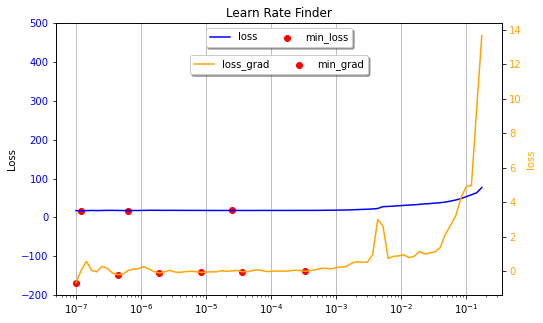

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            3.3113113022E-04     2.5118864869E-05
Second choice lr:           3.6307807022E-05     6.3095734504E-07
Third choice lr:            8.3176373664E-06     1.2022644569E-07


In [85]:
lr = find_optimal_lr(learn)

In [86]:
learn.fit_one_cycle(13, slice(2.5118864869E-05))

epoch,train_loss,valid_loss,time
0,17.878538,16.628782,01:06
1,17.870550,16.655556,01:08
2,17.972300,16.627090,01:09
3,17.842352,16.637362,01:08
4,17.992001,16.669962,01:10
5,17.976139,16.602610,01:09
6,17.850517,16.651390,01:10
7,17.742601,16.630657,01:08
8,17.814075,16.690056,01:08
9,17.753017,16.611563,01:09


In [87]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,44.172924,#na#,01:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


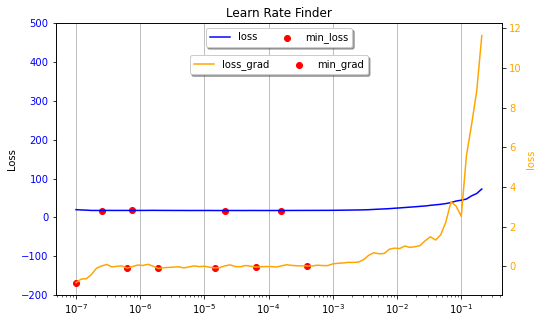

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            3.9810716407E-04     1.5848931798E-04
Second choice lr:           6.3095736550E-05     2.0892961402E-05
Third choice lr:            1.4454397387E-05     7.5857758475E-07


In [88]:
lr = find_optimal_lr(learn)

In [91]:
learn.fit_one_cycle(5, slice(1E-6))

epoch,train_loss,valid_loss,time


AssertionError: If capturable=False, state_steps should not be CUDA tensors.

In [ ]:
learn.save(path/'ssd_unfreeze_6')

In [ ]:
learn.load(path/'ssd_unfreeze_6', strict=True)

### Display predicted image and ground truth

In [92]:
# Get batch from valid dataset
xb,yb = next(iter(learn.data.valid_dl))
xb.shape

# Predict results based on the input image batch
learn.model.eval()
preds = learn.model(xb)

In [93]:
# Select sample image and unpad it
idx = 0
t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
#t_bbox,t_clas

# Predicted class
p_cls_test = preds[1][idx][:,1:].max(dim=1)
#p_cls_test

# Threshold
idx_clas = p_cls_test[0].sigmoid() > 0.1
#idx_clas


p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
#p_f_clas

In [133]:
def show_img_by_ndx(idx):
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    p_cls_test = preds[1][idx][:,1:].max(dim=1)
    idx_clas = p_cls_test[0].sigmoid() > 0.1
    p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)


    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
    t_bbox = p_final_bbox.to(device).index_select(dim=0,index=idx_clas.nonzero().squeeze())
    test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())
    p_img_box = ImageBBox.create(224,224,t_bbox.cpu().detach().numpy(),test_clas,classes=data.classes,scale=False)

    fig,axes = plt.subplots(1,2,figsize=(10,6))
#     import pdb
#     pdb.set_trace()
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction')

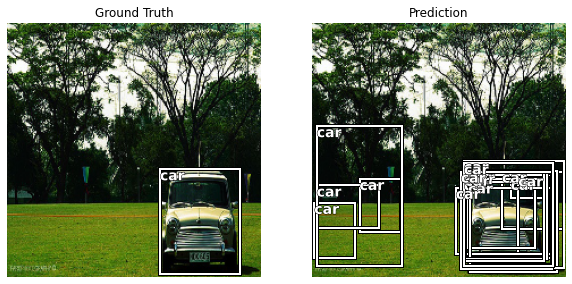

In [134]:
show_img_by_ndx(15)

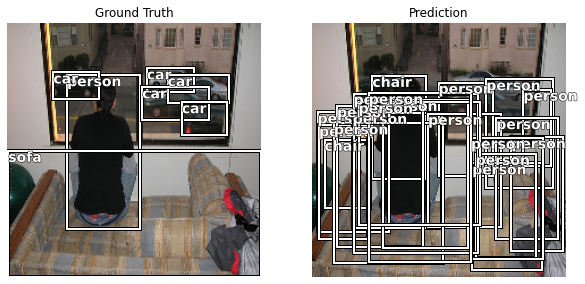

In [135]:
show_img_by_ndx(2)

### Non-Max Suppression

In [136]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

### NMS  Algorithm

In [137]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

### Image Filtering Methods

In [138]:
# Get batch from valid dataset
xb,yb = next(iter(learn.data.valid_dl))

# Predict results based on the input image batch
learn.model.eval()
preds = learn.model(xb)
b_bb, b_clas = preds

In [139]:
def process_nmf(idx):
    '''
    Connects to the nmf algorith to filter out dupplicate bounding boxes
    ''' 
    # Minimun threshold for eliminating background noise
    min_thresh = 0.30     #0.25
    
    # Maximun threshold for eliminating duplicate boxes
    max_thresh = 0.1 
    
     # Extract predicted classes
    clas_pr, clas_ids = b_clas[idx].max(dim=1)
    
    # Mask Index of classes whose contents are over the noise level: 0 if the index contains no boxes, 1 if it does
    clas_pr = clas_pr.sigmoid()    
    
    # Calculate confidence score for Class Activations
    conf_scores = b_clas[idx].sigmoid().t().data  
    
    # Converts activation vectors to boxes. Shape: 189 x 4
    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors) 
    
    # lists for accumulating selected boxes and classes
    tot_bx, tot_cls = [], []
    
    scrd_cls_lst = data.classes.copy()
  
    # Loop across all classes
    for cl in range(0, len(conf_scores)):
        
        # Filter out Backgrounds and empty box arrays
        c_mask = conf_scores[cl] > min_thresh
        if c_mask.sum() == 0 or cl == 0: continue
        
        
        # scores for the selected class 
        scores = conf_scores[cl][c_mask] # Tensor 
            
        # These are active boxes. Ready to be processed by nmf
        boxes = p_final_bbox.to(device).index_select(dim=0,index=c_mask.nonzero().squeeze())
            
        # Run NMF
        ids, count = nms(boxes.data, scores, overlap=0.5, top_k=50)
        ids = ids[:count]
        
    
        
        # Filter all boxes & classes over the threshold and accumulate them in lists
        for i, (sc, bx) in enumerate(zip(scores, boxes.data[ids] )): 
                 
            tot_bx.append(bx)
            tot_cls.append(cl)
            # Create a scored label
            f = f'{i}: '           
            l = f'{data.classes[cl]} '
            s = '{0:.2f}'.format(sc) 
            sl = f+l+s
            # print('scored label: {} '.format(sl))
            scrd_cls_lst[cl] = sl

                
    if not tot_cls:
        print('Inferred Class list is empty. Image may be too faint.')
        return None, None, None  
    
    return torch.cat(tot_bx).view(-1, 4), torch.tensor((np.array(tot_cls))), scrd_cls_lst

In [140]:
# Filter Single Image
def show_filtered_img_by_ndx(idx):
    
    
    # Prepare ground-truth image for display
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))        
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)
    
    # Unpad Y (ground-truth boxes and classes )
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
     
    # Process NMF 
    tot_bx, tot_cls, scrd_cls_lst = process_nmf(idx)  # Filter dupplicate boxes
    if tot_bx is None: return 
    
    # Compose the image, bouding boxes, ans classes for display
    p_img_box = ImageBBox.create(224,224,tot_bx.cpu(),tot_cls.cpu(),classes=scrd_cls_lst,scale=False)
  
    # Display resulting image, selected bounding boxes, and class labels
    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction', color=colr_list[11])
   
 

### Filter Image Sets

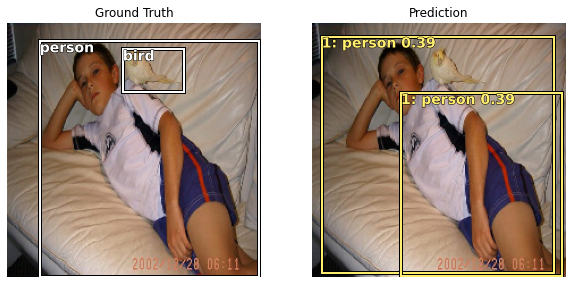

In [141]:
#Filter Image Sets
show_filtered_img_by_ndx(8)

Inferred Class list is empty. Image may be too faint.
Inferred Class list is empty. Image may be too faint.
Inferred Class list is empty. Image may be too faint.
Inferred Class list is empty. Image may be too faint.
Inferred Class list is empty. Image may be too faint.
Inferred Class list is empty. Image may be too faint.


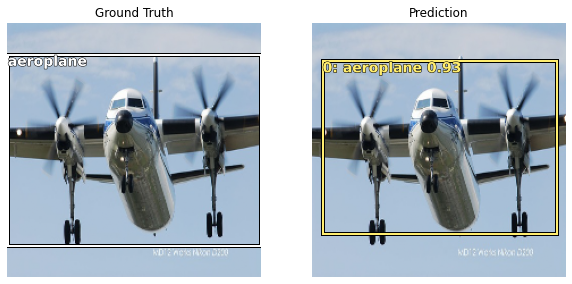

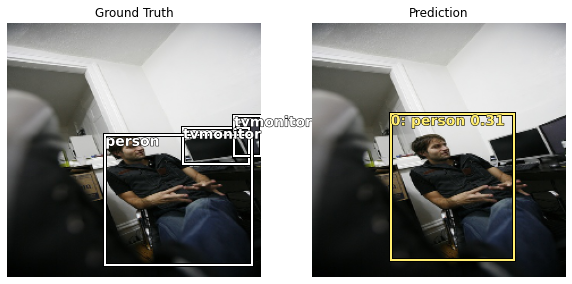

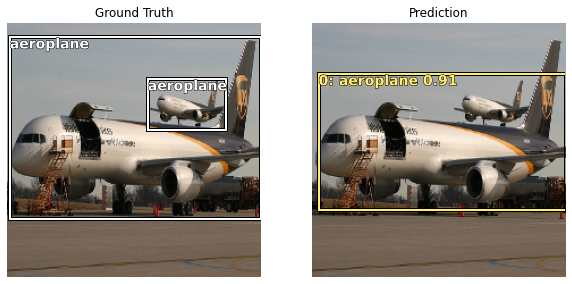

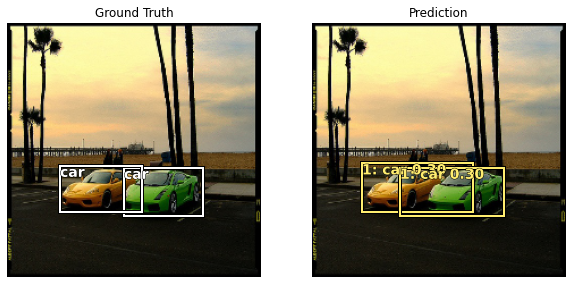

In [142]:
for i in range(30,40): show_filtered_img_by_ndx(i)

# FIN

In [40]:
id2cats = data.classes

# 收集各个类别的个数
def count(L):
    result = collections.defaultdict(int)
    if L is not None:
        for x in L:
            result[x] += 1
    return result

def get1preds(b_clas,b_bb,bbox,clas,thresh=0.25):
    bbox,clas = get_y(bbox, clas)   # 真实bbox，clas
    a_ic = actn_to_bb(b_bb, anchors)# 预测框转为bbox
    clas_pr, clas_ids = b_clas.max(1)# 提取预测的类别，每行取最大值。
    conf_scores = b_clas.sigmoid().t().data # 预测置信度
    out1,out2,cc = [],[],[]
    for cl in range(conf_scores.size(0)-1):
        cl_mask = conf_scores[cl] > thresh # 每一行，取出>0.25的类别
        if cl_mask.sum() == 0: continue
#         import pdb
#         pdb.set_trace()
        scores = conf_scores[cl][cl_mask]
        l_mask = cl_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc)) if cc != [] else None
    out1 = torch.cat(out1) if out1 != [] else None
    out2 = torch.cat(out2) if out2 != [] else None
    return out1,out2,cc


from ipywidgets import FloatProgress
from IPython.display import display

def multiTPFPFN():
    n = 40
    threshes = np.linspace(.05, 0.95, n, endpoint=True)
    tps,fps,fns = np.zeros((n,len(id2cats))),np.zeros((n,len(id2cats))),np.zeros((n,len(id2cats)))
    prog = FloatProgress(min=0,max=len(data.valid_dl))
    display(prog)
    for data in data.valid_dl:
        x,y = data
        x,y = V(x),V(y)
        pred = learn.model(x)
        for idx in range(x.size(0)):
            bbox,clas = get_y(y[0][idx],y[1][idx])#unpad the target
            p_scrs,p_box,p_cls = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],threshes[0])
            if p_box is None:continue
#             import pdb
#             pdb.set_trace()
            overlaps = to_np(jaccard(p_box,bbox.data))
            overlaps = np.where(overlaps > 0.5, overlaps, 0)
            clas, np_scrs, np_cls = to_np(clas.data),to_np(p_scrs), to_np(p_cls)
            for k in range(threshes.shape[0]):# 逐个置信度的检查
                new_tp = collections.defaultdict(int)
                for cls in list(set(clas)):
                    msk_clas = np.bitwise_and((clas == cls)[None,:],(np_cls == cls)[:,None])
                    ov_clas = np.where(msk_clas,overlaps,0.)
                    mx_idx = np.argmax(ov_clas,axis=1)
                    for i in range(0,len(clas)):
                        if (clas[i] == cls):
                            keep = np.bitwise_and(np.max(ov_clas,axis=1) > 0.,mx_idx==i)
                            keep = np.bitwise_and(keep,np_scrs > threshes[k])
                            if keep.sum() > 0:
                                new_tp[cls] += 1
                count_pred = count(np_cls[np_scrs > threshes[k]])
                count_gt = count(clas)
                for c in range(len(id2cats)):
                    tps[k,c] += new_tp[c]
                    fps[k,c] += count_pred[c] - new_tp[c]
                    fns[k,c] += count_gt[c] - new_tp[c]
        prog.value += 1 
    return tps, fps, fns


def plot_prec_recall(clas):
    prec = np.where(tps[:,clas] + fps[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fps[:,clas]), 1)
    recal = np.where(tps[:,clas] + fns[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fns[:,clas]), 1)
    plt.plot(recal,prec)


"""
    计算每个类别的mAP
"""
def avg_prec(clas):
    # 获取所有类别的tps, fps, fns
    tps, fps, fns = multiTPFPFN()
    precisions = np.where(tps[:,clas] + fps[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fps[:,clas]), 1)
    recalls = np.where(tps[:,clas] + fns[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fns[:,clas]), 1)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    return np.array(prec_at_rec).mean()

def mAP():
    S = 0
    for i in range(len(id2cats)):
        S += avg_prec(i)
    return S/len(id2cats)


In [43]:
data.valid_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f91cfe36cd0>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f91cfeaac10>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function bb_pad_collate at 0x7f91cfeaaa60>)